# Co-clustering in Spark

This noteboo attempts to execute in Spark the co-clustering algorithm presented in [co_clustering_R](../r/co_clustering_R.ipynb) which is the implementation of Bregman block average co-clustering algorithm (Banerjee et al., 2007) and it is inpired in the [single node impementation](https://github.com/fnyanez/bbac), [Copyright (c) 2016 Felipe Yanez](https://github.com/fnyanez/bbac/blob/master/LICENSE.md).

Next to the Python code the user will see the R code in Markdown format.

## Dependencies

In [1]:
#Add all dependencies to PYTHON_PATH
import sys
sys.path.append("/usr/lib/spark/python")
sys.path.append("/usr/lib/spark/python/lib/py4j-0.10.4-src.zip")
sys.path.append("/usr/lib/python3/dist-packages")

#Define environment variables
import os
os.environ["HADOOP_CONF_DIR"] = "/etc/hadoop/conf"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "ipython"

#Load PySpark to connect to a Spark cluster
from pyspark import SparkConf, SparkContext

#from osgeo import gdal
#To read GeoTiffs as a ByteArray
from io import BytesIO
from rasterio.io import MemoryFile

## Connect to Spark

In [2]:
appName = "co_clustering"
masterURL="spark://pheno0.phenovari-utwente.surf-hosted.nl:7077"

#A context needs to be created if it does not already exist
try:
    sc.stop()
except NameError:
    print("A  new Spark Context will be created.")
    
sc = SparkContext(conf = SparkConf().setAppName(appName).setMaster(masterURL))

A  new Spark Context will be created.


### Support functions

```
coCavg <- function(dist, row_col, R, Z, C, W, epsilon) {
  CoCavg <- calculate_average(R, Z, C, W, epsilon)
  if (row_col=="row") {
    return(list(Zrowc = array(dist, dim(Z)), Zrowv = CoCavg %*% t(C)))
  } else if (row_col=="col") {
    return(list(Zcolc = array(dist, dim(Z)), Zcolv = R %*% CoCavg))
  }
}
```

```
calculate_average <- function(Left, Z, Right, W, epsilon) {
  if (is.null(W)) {W <- array(1, dim(Z))} else {Z <- W * Z}
  numerator <- t(Left) %*% Z %*% Right + mean(Z) * epsilon
  denominator <- t(Left) %*% W %*% Right + epsilon
  return(numerator/denominator)
}
```

```
similarity_measure <- function(dist, Z, X, Y, W, epsilon) {
  if (is.null(W)) W <- array(1, dim(Z))
  if (dist==0) {
    euc <- function(i) rowSums(W * (Z - X - rep(Y[i,], each = dim(Z)[1]))^2)
    return(sapply(1:dim(Y)[1], euc))
  } else if (dist==1) {
    return((W * X) %*% t(Y + epsilon) - (W * Z) %*% log(t(Y + epsilon)))
  }
}
```

```
assign_cluster <- function(dist, Z, X, Y, W, epsilon) {
  D <- similarity_measure(dist, Z, X, Y, W, epsilon)
  id <- sapply(1:dim(D)[1], function(i) sort(D[i,], index.return = TRUE)$ix[1])
  res <- sapply(1:dim(D)[1], function(i) sort(D[i,])[1]^(2-dist))
  return(list(Cluster = diag(dim(Y)[1])[id,], Error = sum(res)))
}
```

### BBAC
```
Z - m x n data matrix, 
W - m x n measure matrix, 
k - num row clusters,
l - num col clusters
```

```
bbac <- function(matrixDF, numRowC, numColC, W = NULL, distance = "euclidean", errobj = 1e-6, niters = 100, nruns = 5, epsilon = 1e-8) {
  
  error <- Inf
  error_now <- Inf
  dist <- pmatch(tolower(distance), c("euclidean","divergence")) - 1
  
  for (r in 1:nruns) {
    
    # Initialization of R and C
    R <- diag(numRowC)[base::sample(numRowC, dim(matrixDF)[1], replace = TRUE),]
    C <- diag(numColC)[base::sample(numColC, dim(matrixDF)[2], replace = TRUE),]
    
    for (s in 1:niters) {
      
      # Row estimation
      rs <- coCavg(dist, "row", R, matrixDF, C, W, epsilon)
      ra <- assign_cluster(dist, matrixDF, rs$Zrowc, rs$Zrowv, W, epsilon)
      R  <- ra$Cluster
      
      # Column estimation
      cs <- coCavg(dist, "col", R, matrixDF, C, W, epsilon)
      ca <- assign_cluster(dist, t(matrixDF), t(cs$Zcolc), t(cs$Zcolv), W, epsilon)
      C  <- ca$Cluster
      
      # 
      if (abs(ca$Error - error_now) < errobj) {
        status <- paste("converged in",s,"iterations")
        return(list(R = R, C = C, status = status))
      }
      
      # Update objective value
      error_now <- ca$Error
      
    }
    
    # Keep pair with min error
    if (error_now < error) {
      R_star <- R
      C_star <- C
      error <- error_now
    }
    
  }
  
  status <- paste("reached maximum of", niters, "iterations")
  return(list(R = R_star, C = C_star, status = status))
  
}
```

### Run 

```
set.seed(1)
input_matrix <- matrix(rep(1:4, 25), 10, 10)

# Run co-clustering algorithm
bbac_res <- bbac(matrixDF, k = 2, l = 2, distance = "e")


```

### Plot results
```
plot_coclusters <- function(Z, R, C) {
  # Sort matrix
  Y <- t(Z[(R * (1:nrow(R)))[R != 0], (C * (1:nrow(C)))[C != 0]])
    
  # Plot sorted matrix
  image(seq(0, 1, length.out = dim(Y)[1]), seq(0, 1, length.out = dim(Y)[2]),
        Y, col = grey((0:12)/12), axes = FALSE, xlab = "", ylab = "")
    
  # Print row clusters
  row_clust <- (head(cumsum(colSums(R)), -1) - 0.5)/(ncol(Y) - 1)
  invisible(sapply(1:length(row_clust), function(i) 
    segments(-0.5, row_clust[i], 1.5, row_clust[i], col = 2, lwd = 2)))
  
  # Print column clusters
  col_clust <- (head(cumsum(colSums(C)), -1) - 0.5)/(nrow(Y) - 1)
  invisible(sapply(1:length(col_clust), function(i) 
    segments(col_clust[i], -0.5, col_clust[i], 1.5, col = 2, lwd = 2)))
}
                   
# Show co-clusters
par(mfrow=c(1, 1))
plot_coclusters(input_matrix, bbac_res$R, bbac_res$C)
title(paste("CoCavg algorithm", bbac_res$status))
```
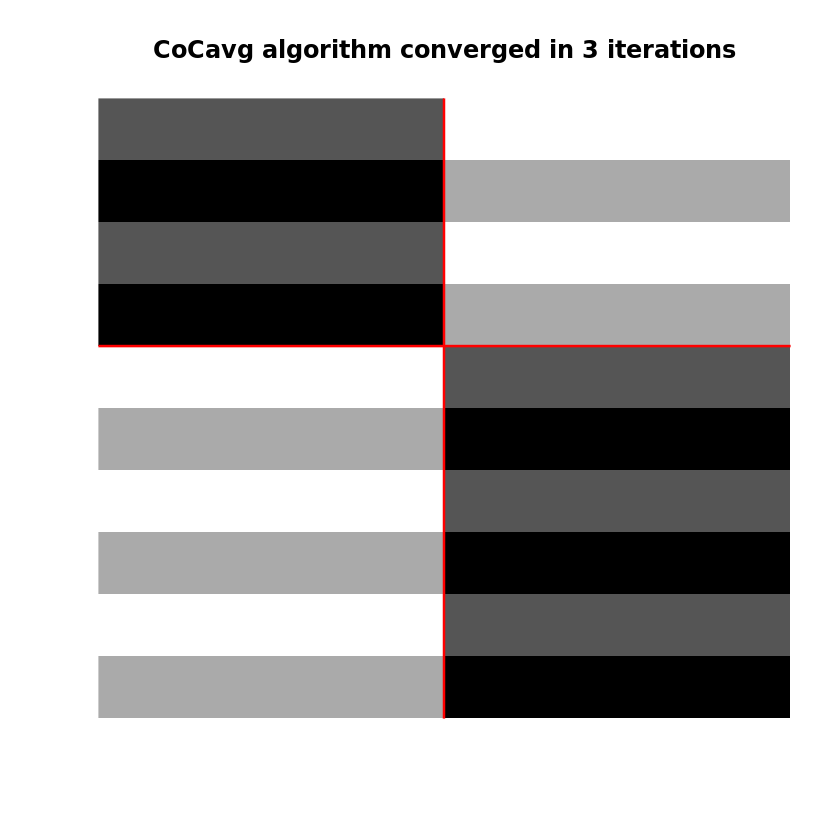